# fits.py

In [1]:
import sys
import numpy as np
codebase_dir = '/Users/juan/ZiaLab/Codebase'
sys.path.append(codebase_dir)
%reload_ext autoreload
%autoreload 2
%load_ext autotime
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import h5py
data_dir = '/Volumes/jlizaraz/ZiaLab/Log/Data'
graphs_dir = '/Volumes/jlizaraz/ZiaLab/Log/Graphs'
from zialab.analysis import fits
%config InlineBackend.figure_format='retina'

# spectrum_3param_fit & spectrum_4param_fit

These two functions can fit data to a number of lineshapes where each term is defined by three parameters (lorentz, gaussian) or by four parameters (pseudo-Voig).
Here's one example using a PLE spectrum obtained from YAP.

In [3]:
with h5py.File('./sample.h5','r') as h5f:
    x = np.array(h5f['/energies'])
    x_unit = h5f['/energies'].attrs['unit']
    y = np.array(h5f['/PL'])
    y_unit = h5f['/PL'].attrs['unit']
    metadata = h5f.attrs['metadata']

Fitting is performed sequentially adding one term at a time. With starting values for the previous terms used from the fit of the previous stage.

In [41]:
max_terms = 20
lorenzo = fits.spectrum_3param_fit(x, y, fits.lorentz_model, max_terms, maxfev=1e6)
carl = fits.spectrum_3param_fit(x, y, fits.gaussian_model, max_terms, maxfev=1e6)
voigt = fits.spectrum_4param_fit(x, y, fits.pseudo_voigt_model, max_terms, maxfev=1e6)

Function returns an array that has the fitted parameters for the various number of terms that are fitted until arriving at the provided number of maximum terms. Here's a set of plots that show the final fit for the three different lineshapes.

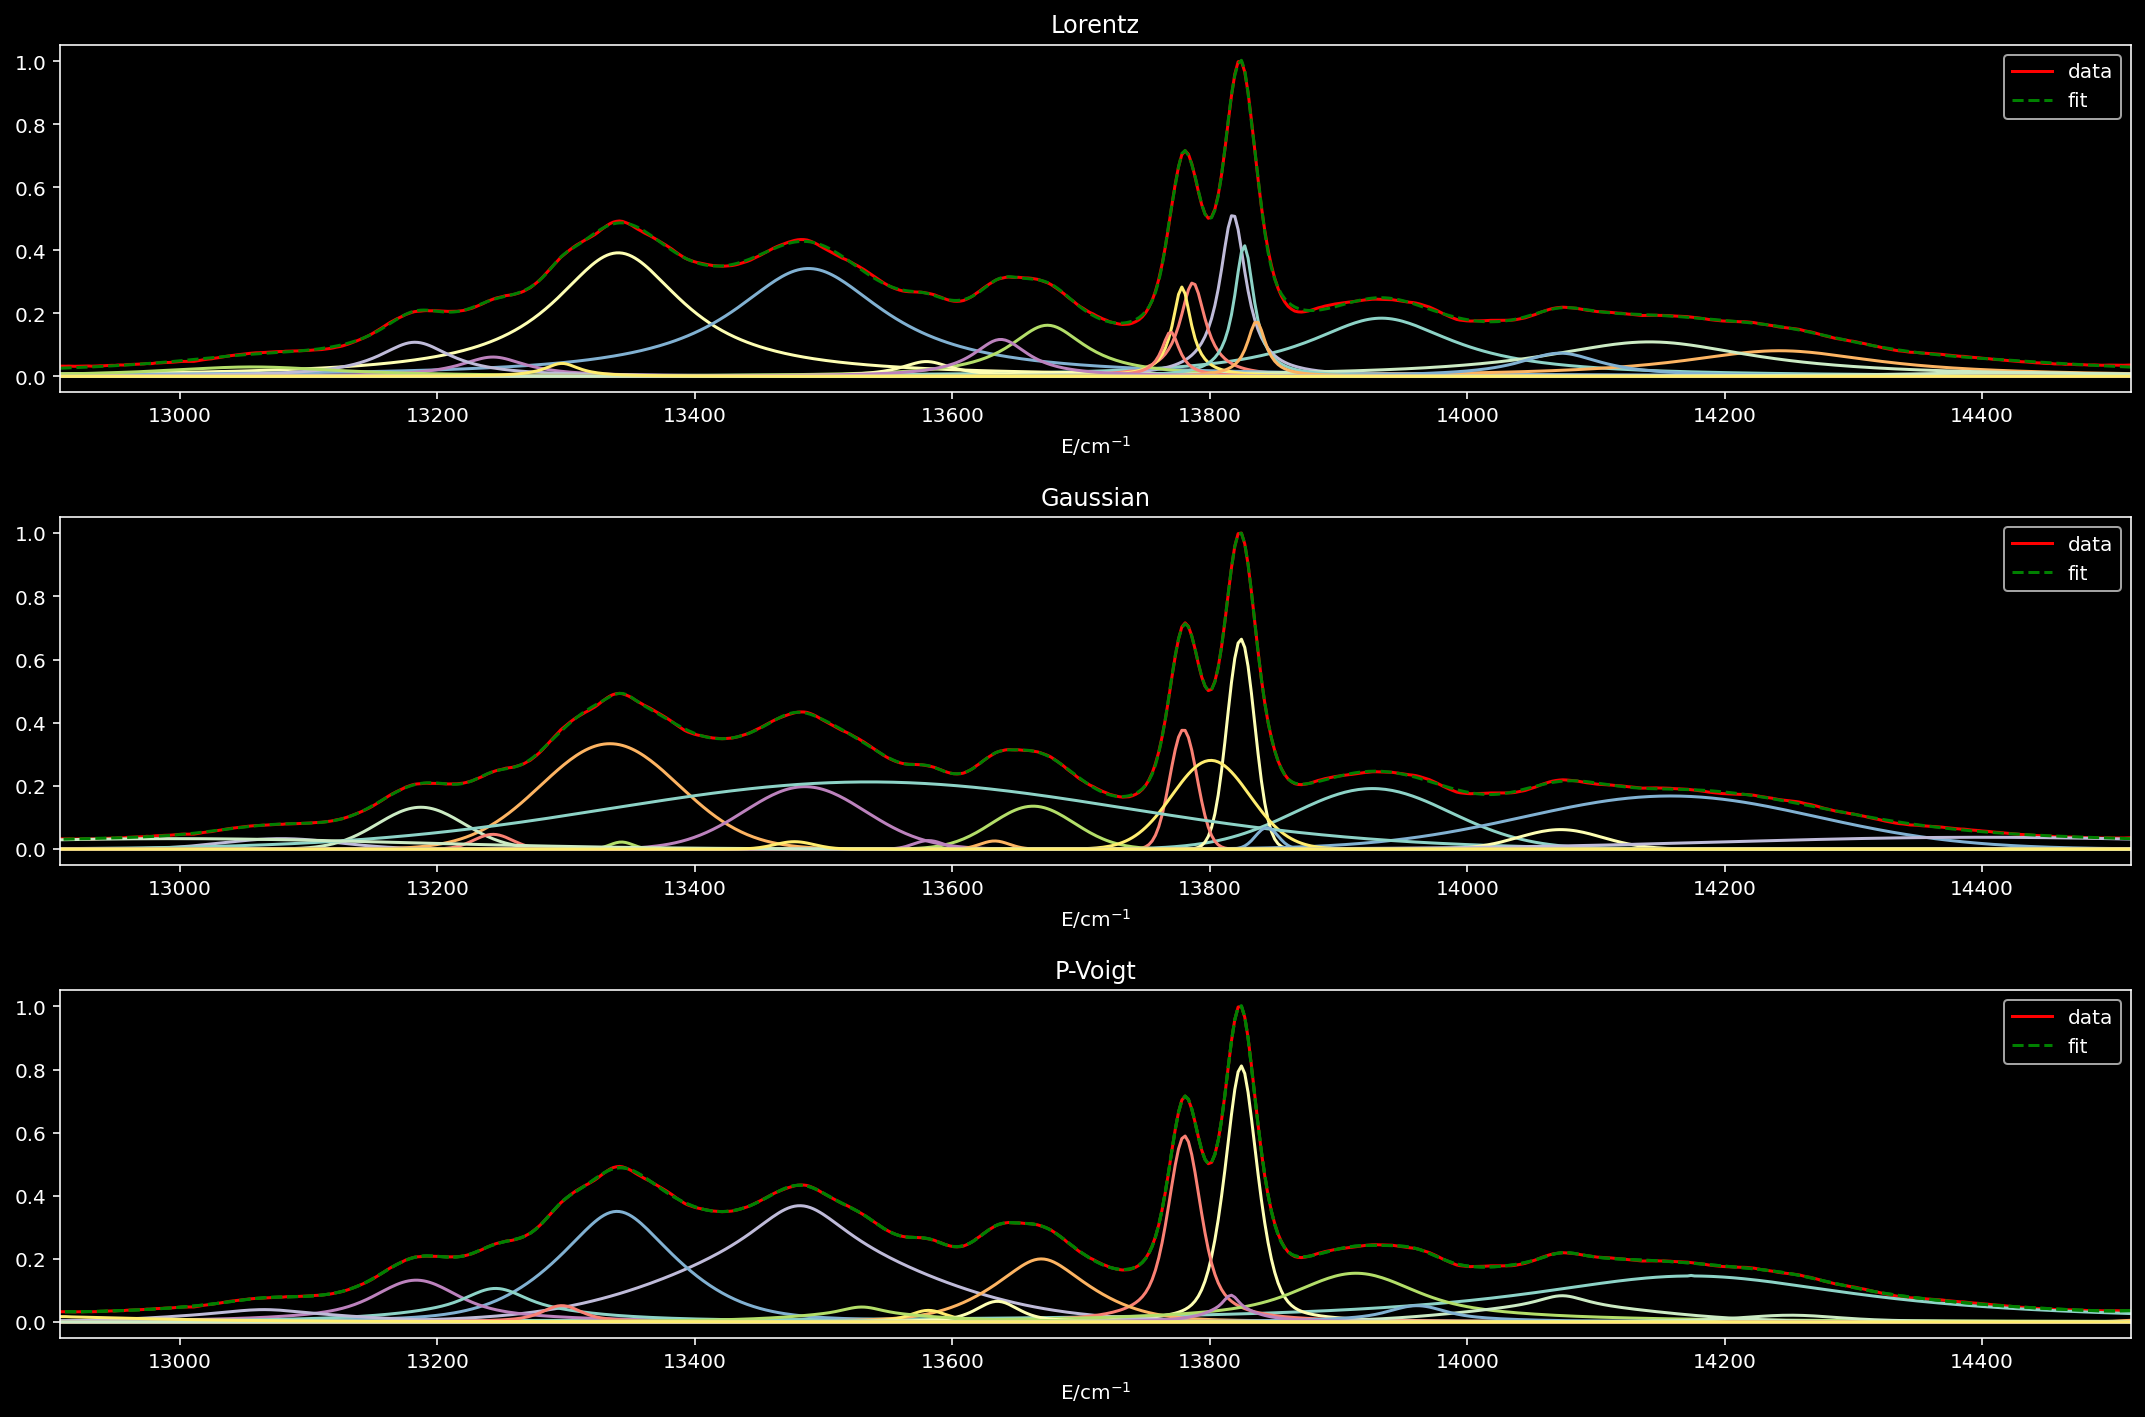

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
for idx, (fitkind, fitfunkind) in enumerate(zip([lorenzo, carl, voigt],[fits.lorentz_model, fits.gaussian_model, fits.pseudo_voigt_model])):
    total_fit = np.zeros(x.shape)
    final_fit = fitkind[0][-1]
    ax[idx].plot(x, y, 'r-', label='data')
    if idx == 2:
        num_terms = len(final_fit)//4
        amplitudes = final_fit[:num_terms]
        center_positions = final_fit[num_terms:2*(num_terms)]
        widthsL = final_fit[2*num_terms:3*num_terms]
        widthsG = final_fit[3*num_terms:]
        fitfun = fitfunkind(1)
        for amp, cp, wG, wL in zip(amplitudes, center_positions, widthsG, widthsL):
            fitpart = fitfun(x, amp, cp, wL, wG)
            total_fit += fitpart
            ax[idx].plot(x,fitpart )
        ax[idx].plot(x, total_fit, 'g--', label='fit')
    else:
        num_terms = len(final_fit)//3
        amplitudes = final_fit[:num_terms]
        center_positions = final_fit[num_terms:2*(num_terms)]
        widthsL = final_fit[2*num_terms:]
        fitfun = fitfunkind(1)
        for amp, cp, wL in zip(amplitudes, center_positions, widthsL):
            fitpart = fitfun(x, amp, cp, wL)
            total_fit += fitpart
            ax[idx].plot(x,fitpart )
        ax[idx].plot(x, total_fit, 'g--', label='fit')
    ax[idx].set_xlabel('E/cm${}^{-1}$')
    ax[idx].set_xlim(min(x), max(x))
    ax[idx].set_title(['Lorentz','Gaussian','P-Voigt'][idx])
    ax[idx].legend()
plt.plot(x, total_fit, 'g--')
plt.tight_layout()
plt.xlim(min(x), max(x))
plt.show()

Here's a plot that compares the cosine dissimilarity against the number of terms used and the number of parameters used.

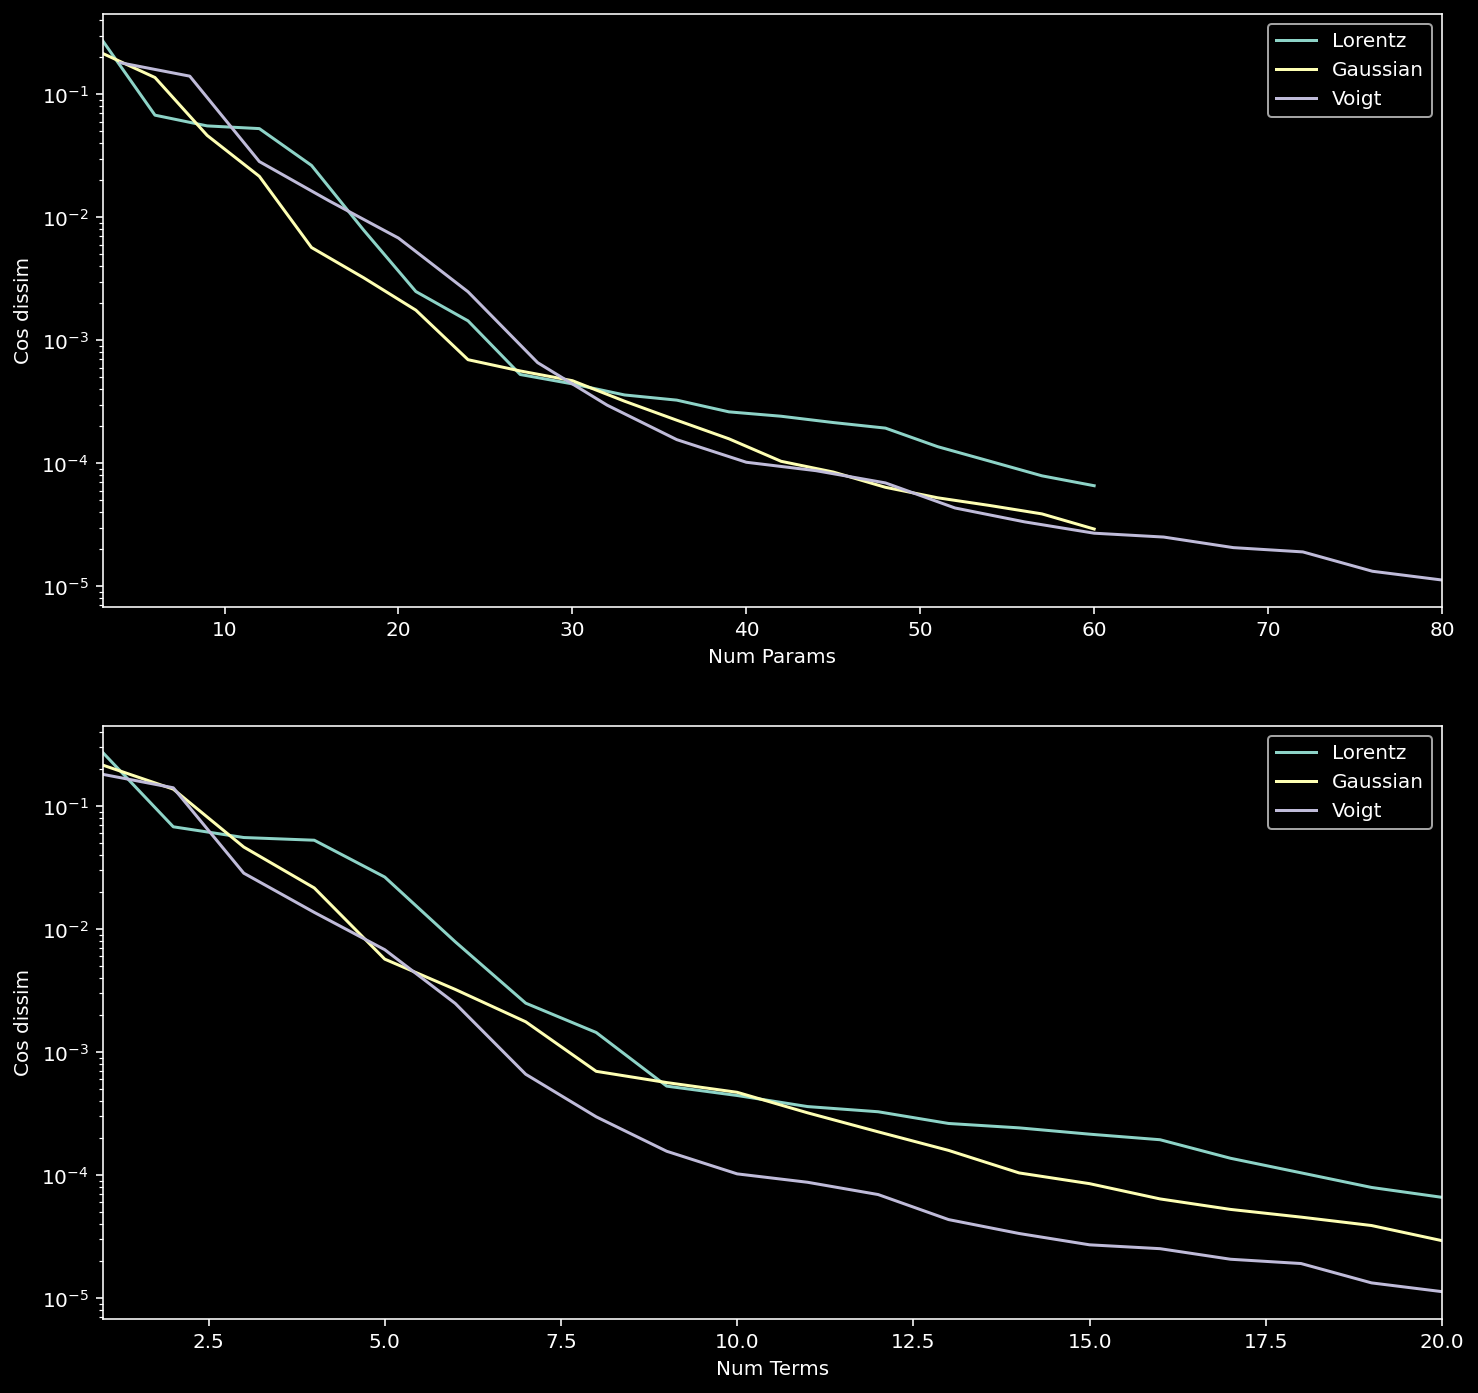

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1 , figsize=(12,12))

ax[0].plot(np.arange(1, max_terms+1)*3, 1-lorenzo[1],label='Lorentz')
ax[0].plot(np.arange(1, max_terms+1)*3, 1-carl[1], label='Gaussian')
ax[0].plot(np.arange(1, max_terms+1)*4, 1-voigt[1], label='Voigt')
ax[0].set_yscale('log')
ax[0].set_xlabel('Num Params')
ax[0].set_ylabel('Cos dissim')
ax[0].set_xlim(3,max_terms*4)
ax[0].legend()

ax[1].plot(np.arange(1,max_terms+1)*1,1-lorenzo[1],label='Lorentz')
ax[1].plot(np.arange(1,max_terms+1)*1,1-carl[1], label='Gaussian')
ax[1].plot(np.arange(1,max_terms+1)*1,1-voigt[1], label='Voigt')
ax[1].set_yscale('log')
ax[1].set_xlabel('Num Terms')
ax[1].set_ylabel('Cos dissim')
ax[1].set_xlim(1,max_terms)
ax[1].legend()

plt.legend()
plt.show()

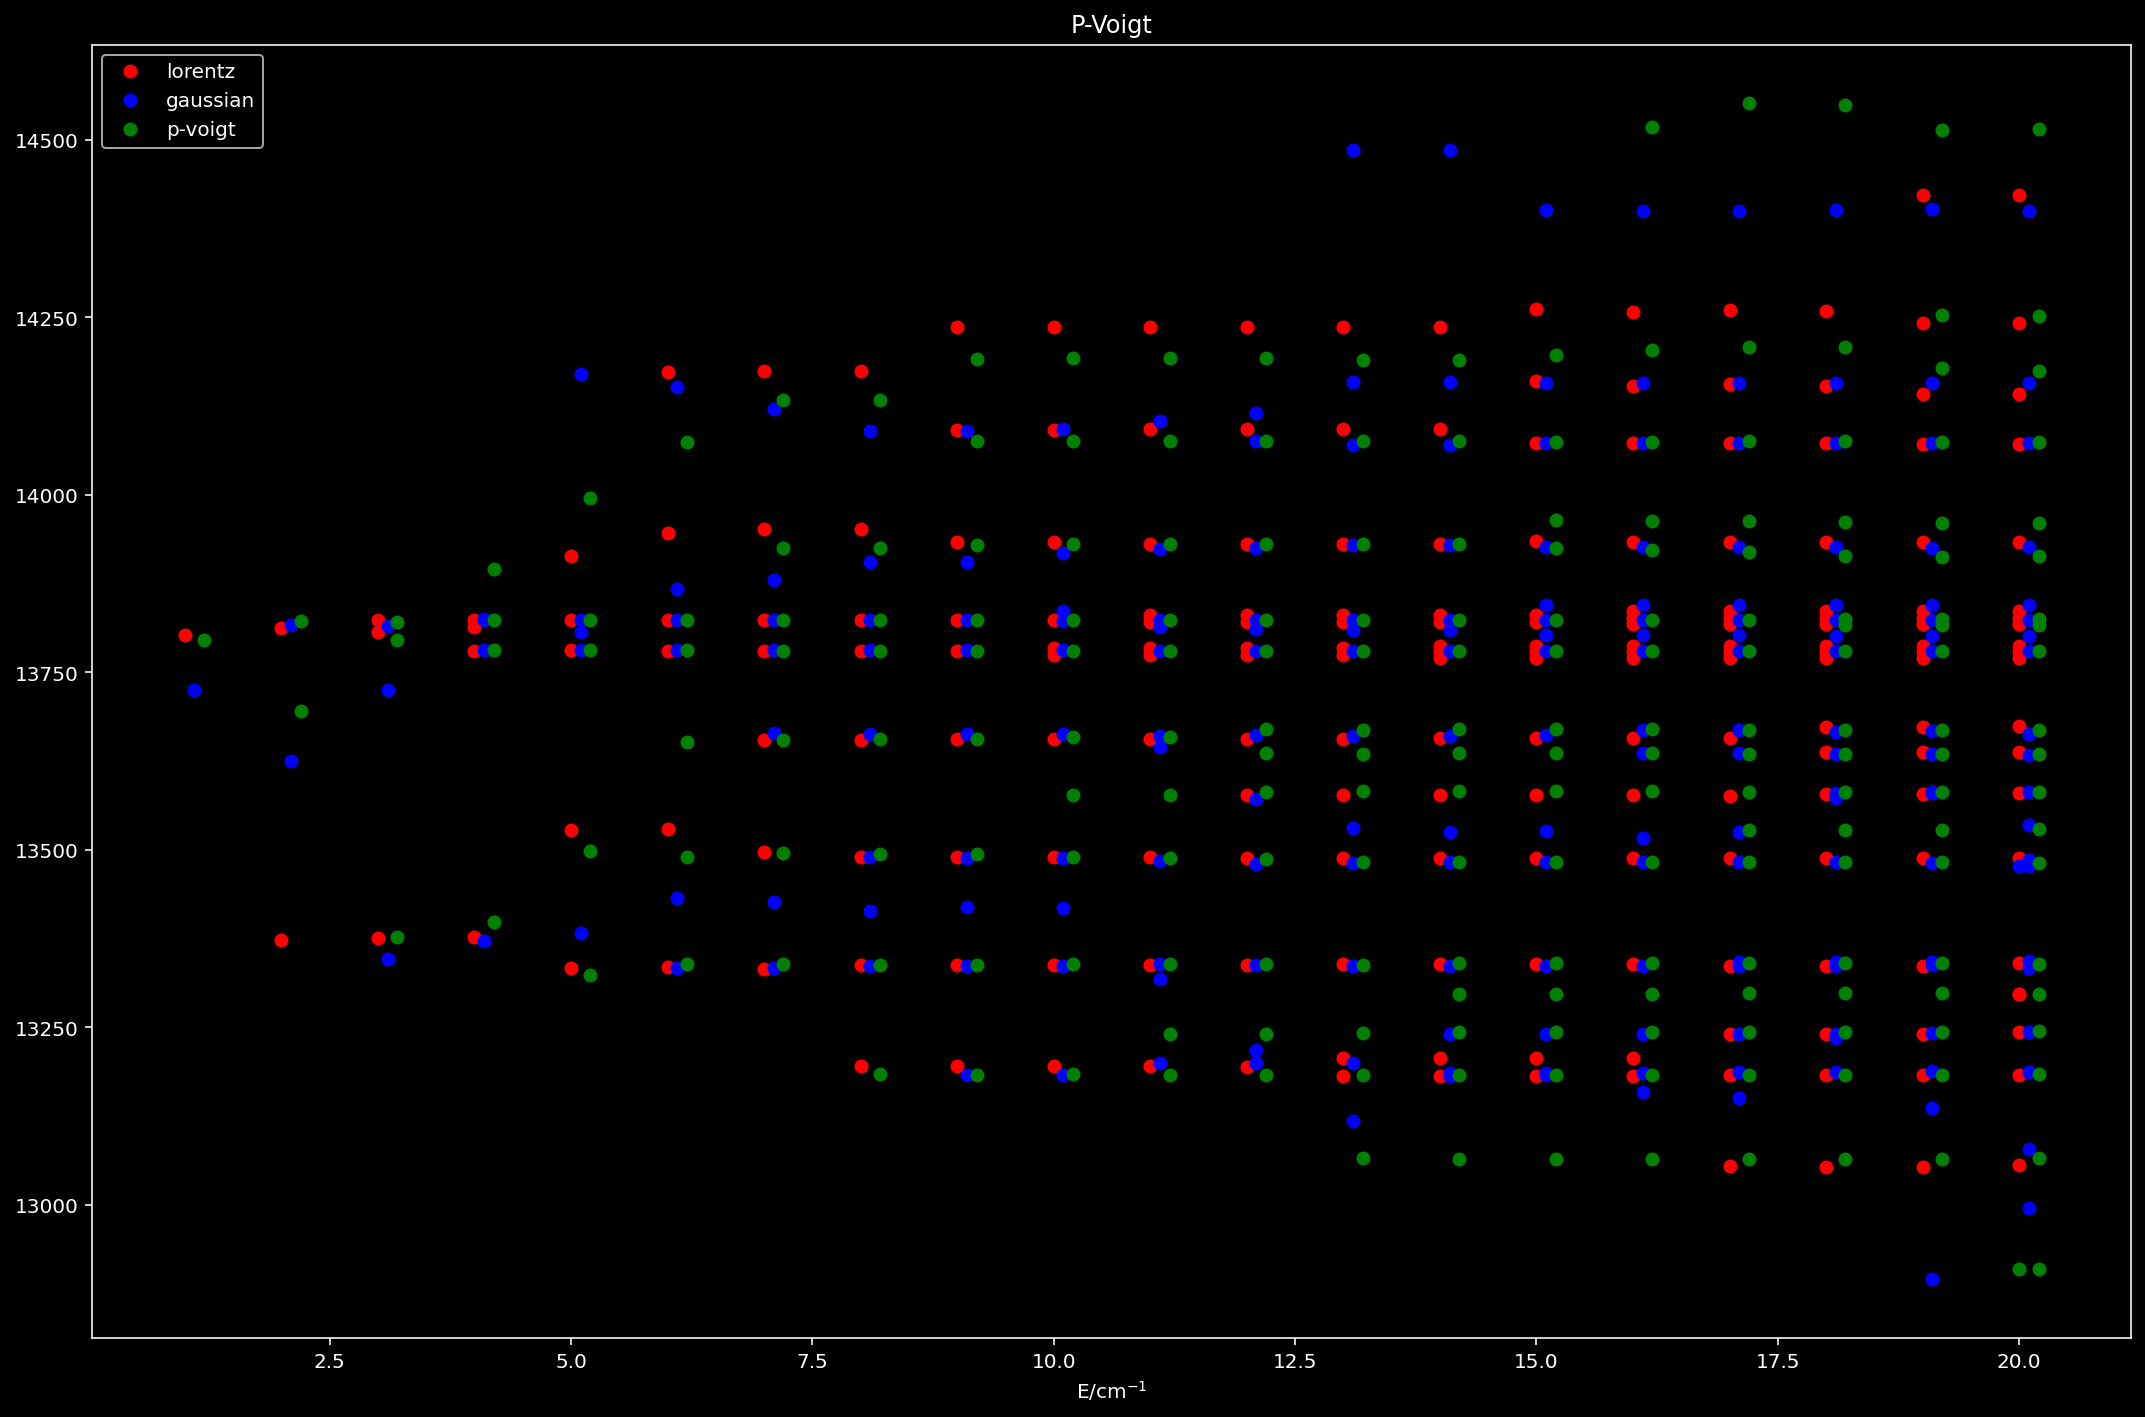

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
for idx, (fitkind, fitfunkind) in enumerate(zip([lorenzo, carl, voigt],[fits.lorentz_model, fits.gaussian_model, fits.pseudo_voigt_model])):
    total_fit = np.zeros(x.shape)
    mcolor = {0:'r',1:'b',2:'g'}[idx]
    for final_fit in fitkind[0]:
        if idx == 2:
            num_terms = len(final_fit)//4
            amplitudes = final_fit[:num_terms]
            center_positions = final_fit[num_terms:2*(num_terms)]
            widthsL = final_fit[2*num_terms:3*num_terms]
            widthsG = final_fit[3*num_terms:]
            fitfun = fitfunkind(1)
            for amp, cp, wG, wL in zip(amplitudes, center_positions, widthsG, widthsL):
                fitpart = fitfun(x, amp, cp, wL, wG)
                total_fit += fitpart
                ax.plot(num_terms + idx/10, cp, mcolor+'o' )
        else:
            num_terms = len(final_fit)//3
            amplitudes = final_fit[:num_terms]
            center_positions = final_fit[num_terms:2*(num_terms)]
            widthsL = final_fit[2*num_terms:]
            fitfun = fitfunkind(1)
            for amp, cp, wL in zip(amplitudes, center_positions, widthsL):
                fitpart = fitfun(x, amp, cp, wL)
                total_fit += fitpart
                ax.plot(num_terms + idx/10, cp, mcolor+'o' )
        ax.set_xlabel('E/cm${}^{-1}$')
        ax.set_title(['Lorentz','Gaussian','P-Voigt'][idx])
    else:
        ax.plot(num_terms, cp, mcolor+'o', label=['lorentz','gaussian','p-voigt'][idx])
plt.legend()
plt.tight_layout()
plt.show()